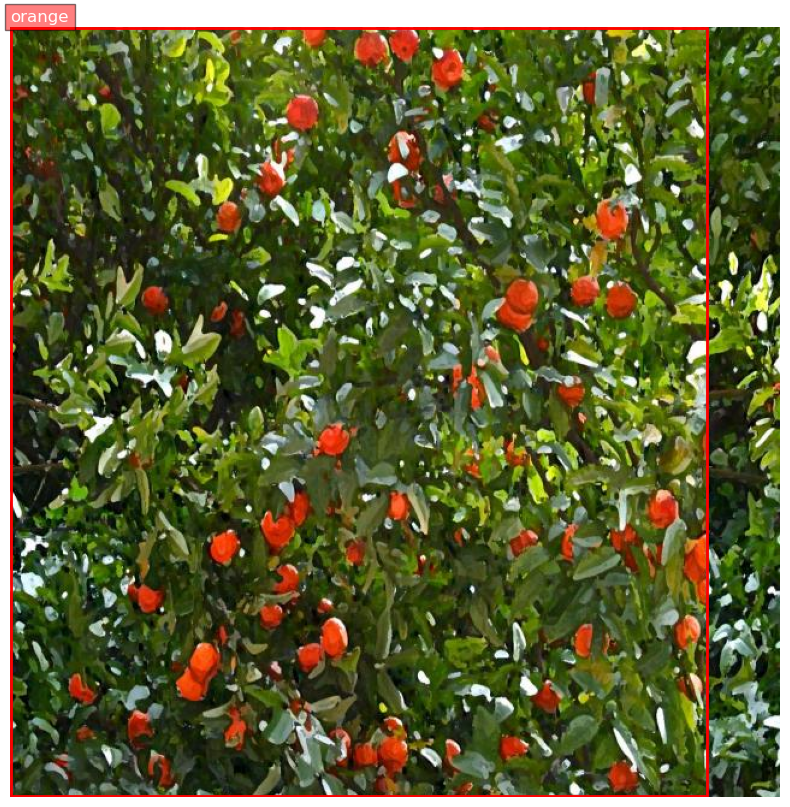

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# --- 步驟 1: 讀取與探索資料 ---

# 【請確認】您需要根據資料集的說明，確認類別 ID 和名稱的對應關係
CLASS_MAPPING = {
    0: 'apple',
    1: 'banana',
    2: 'grapes',
    3: 'orange',
    4: 'pineapple',
    5: 'watermelon',
}

# --- 設定您要視覺化的圖片 ---
# 【請修改】請將這個檔名換成您 train/images/ 資料夾中實際存在的圖片檔名
image_to_visualize = '0a2bfef3b22f77b6_jpg.rf.1a02b2e598332c6a99dda6d89eda1f9c.jpg' 

# ---------------------------------------------

# 建立檔案路徑
image_dir = './train/images/'
label_dir = './train/labels/'

image_path = os.path.join(image_dir, image_to_visualize)
# .txt 檔名通常和圖片檔名一樣，只是副檔名不同
label_filename = os.path.splitext(image_to_visualize)[0] + '.txt'
label_path = os.path.join(label_dir, label_filename)

# --- 讀取圖片與標註檔 ---
# 讀取圖片
img = Image.open(image_path)

# 讀取標註檔
annotations = []
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                # 將剩下的部分轉為 float
                box = [float(p) for p in parts[1:]]
                annotations.append({'class_id': class_id, 'box': box})

# --- 開始繪圖 ---
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

# 畫出所有邊界框
for ann in annotations:
    class_id = ann['class_id']
    box = ann['box']
    
    # 我們的假設是 [x_min, y_min, width, height]
    x_min, y_min, width, height = box
    
    # 建立一個矩形 patch
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    # 將矩形加入到圖片中
    ax.add_patch(rect)
    
    # 在框的左上角加上類別名稱
    class_name = CLASS_MAPPING.get(class_id, 'Unknown')
    plt.text(x_min, y_min - 5, class_name, color='white', fontsize=12, 
             bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
import os
from PIL import Image

# --- 步驟 2: 建立客製化 PyTorch Dataset ---

class FruitDataset(Dataset):
    # 【修正1】讓 init 接收 image_dir 和 label_dir 兩個路徑
    def __init__(self, image_dir, label_dir, transforms=None):
        super().__init__()
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        
        # self.image_names 儲存了所有圖片的檔名
        self.image_names = sorted(os.listdir(self.image_dir))

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx: int):
        # 根據索引 idx，取得圖片檔名
        image_name = self.image_names[idx]
        
        # 【修正1】直接組合圖片路徑，不再加 .jpg
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        
        # 根據圖片檔名，組合出標籤檔的路徑
        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)
        
        # 【修正2】在方法內部建立空的 list 來收集 boxes 和 labels
        boxes_list = []
        labels_list = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        # 【修正3】將每一個 class_id 和 box 都加到 list 中
                        class_id = int(parts[0])
                        
                        x_min, y_min, width, height = [float(p) for p in parts[1:]]
                        # 將 [x, y, w, h] 轉換為 [x_min, y_min, x_max, y_max]
                        x_max = x_min + width
                        y_max = y_min + height
                        
                        boxes_list.append([x_min, y_min, x_max, y_max])
                        labels_list.append(class_id)

        # 【修正3】將收集完的 list 轉換為 Tensor
        # 如果圖片中沒有任何物件，則回傳空的 Tensor
        boxes = torch.as_tensor(boxes_list, dtype=torch.float32)
        labels = torch.as_tensor(labels_list, dtype=torch.int64)

        # 建立目標 (target) 字典
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        # 套用 transforms
        if self.transforms:
            image = self.transforms(image)
            
        return image, target

In [5]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- 步驟 3: 準備預訓練的物件偵測模型 ---

# 載入一個在 COCO 上預訓練好的 Faster R-CNN 模型
# weights=...V1 是目前建議的用法
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')

# --- 改造分類頭 ---

# 取得我們資料集的類別數量 (1個類別 'wheat' + 1個背景類別 '_')
num_classes = 7 

# 取得模型分類器的輸入特徵數量
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 用一個新的分類頭替換掉預訓練好的頭
# FastRCNNPredictor 是一個 PyTorch 提供的輔助類別
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 將模型移動到 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print("模型改造完成！")
# 您可以印出 model.roi_heads.box_predictor 來看看，
# 會發現它的 out_features 已經變成 2 了。
print(model.roi_heads.box_predictor)

模型改造完成！
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=7, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=28, bias=True)
)


In [7]:
from torch.utils.data import DataLoader
from torchmetrics.detection import MeanAveragePrecision
import torch

# --- 步驟 4: 訓練模型 ---

# --- 準備 DataLoader ---
# 建立 transforms (這裡先用最簡單的 ToTensor)
# 之後您可以自己加入資料增強的 transforms
transforms = torchvision.transforms.ToTensor()

# 建立 Dataset 物件
# 【請注意】請確認 image_dir 和 label_dir 的路徑是正確的
full_dataset = FruitDataset(
    image_dir='./train/images/', 
    label_dir='./train/labels/', 
    transforms=transforms
)

# 分割訓練集和驗證集 (例如 80% 訓練, 20% 驗證)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

def collate_fn(batch):
    return tuple(zip(*batch))

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# --- 準備優化器 ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5 # 您可以增加 epoch 數量以獲得更好效果

# --- 開始訓練 ---
print("開始訓練...")
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {losses.item():.4f}')

print('訓練完成!')

# --- 開始評估 ---
print("\n開始評估...")
metric = MeanAveragePrecision(box_format='xyxy')
model.eval()
with torch.no_grad():
    for images, targets in val_loader: # 在驗證集上評估
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        predictions = model(images)
        metric.update(predictions, targets)

results = metric.compute()
print("\n--- 模型評估結果 ---")
print(results)

開始訓練...
Epoch [1/5], Step [50/1526], Loss: 0.1945
Epoch [1/5], Step [100/1526], Loss: 0.2309
Epoch [1/5], Step [150/1526], Loss: 0.1918
Epoch [1/5], Step [200/1526], Loss: 0.2797
Epoch [1/5], Step [250/1526], Loss: 0.3150
Epoch [1/5], Step [300/1526], Loss: 0.1108
Epoch [1/5], Step [350/1526], Loss: 0.1769
Epoch [1/5], Step [400/1526], Loss: 0.5239
Epoch [1/5], Step [450/1526], Loss: 0.1749
Epoch [1/5], Step [500/1526], Loss: 0.4836
Epoch [1/5], Step [550/1526], Loss: 0.1222
Epoch [1/5], Step [600/1526], Loss: 0.1892
Epoch [1/5], Step [650/1526], Loss: 0.2944
Epoch [1/5], Step [700/1526], Loss: 0.2042
Epoch [1/5], Step [750/1526], Loss: 0.1892
Epoch [1/5], Step [800/1526], Loss: 0.2049
Epoch [1/5], Step [850/1526], Loss: 0.2261
Epoch [1/5], Step [900/1526], Loss: 0.1300
Epoch [1/5], Step [950/1526], Loss: 0.6946
Epoch [1/5], Step [1000/1526], Loss: 0.0743
Epoch [1/5], Step [1050/1526], Loss: 0.4458
Epoch [1/5], Step [1100/1526], Loss: 0.1057
Epoch [1/5], Step [1150/1526], Loss: 0.0954
